In [21]:
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
import ringdown.qnms
import makefun
from scipy.optimize import curve_fit
import statistics
import matplotlib.lines as mlines
import pandas as pd

In [22]:
# define what modes to use
def rd_fun(modes=[(2,2,0),(2,2,1)]):
    #create function signature
    func_signature="rngdwn_multi_modes(time,M,chi"
    # loop through defined modes
    for mode in modes:
        l,m,n = mode
        func_signature+= f",a{l}{m}{n},phi{l}{m}{n}"
    func_signature+=")"
    # kwargs = a220, phi220, a221, phi221, ...
    def new_fun(time,M,chi,**kwargs):
        # creating empty time array to hold rngdwn() return
        ex = np.zeros(time.shape)
        # loop through defined modes
        for mode in modes:
            l,m,n=mode
            amplitude=kwargs[f"a{l}{m}{n}"]
            phi=kwargs[f"phi{l}{m}{n}"]
            # add back to empty time array  
            ex += rngdwn(time,M,chi,l,m,n,amplitude,phi)
            #print(time,M,chi,kwargs)
        # return ex to have combined signal for all defined modes
        return ex
    # this fx now looks like what scipy.curve_fit expects...
    return makefun.create_function(func_signature,new_fun)

# let "test = rd_fun" // test now takes inputs of (time,M,chi,a220,phi220,a221,phi221) --> curve_fit can play with
test = rd_fun(modes=[(2,1,0),(2,1,1),(2,1,2),
                     (2,2,0),(2,2,1),(2,2,2),
                     (3,2,0),(3,2,1),(3,2,2),
                     (3,3,0),(3,3,1),(3,3,2),
                     (4,4,0),(4,4,1),(4,4,2)]
             )



def rngdwn(time,M,chi,l,m,n,amplitude,phi):
    # using get_ftau to retrieve frequency and damping time for given values (ftau = [freq, tau])
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],                                                            
    gamma = gamma,                                                          
    )
    # generate sinusoid
    s = amplitude*np.cos(2*np.pi*ftau[0]*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
    return ringdown.Data(s, index=time)



def plot_ringdown(x0,xdata,ydata,p0,bounds,approx):  

    popt,pcov = curve_fit(x0,xdata,ydata,p0,bounds=bounds)
    
    #changing timeseries to array
    ydata_array = ydata.data
    x0_exp = x0(xdata, *popt)._values
    # calculating r**2 value
    r = ydata_array - x0_exp 
    ss_res = np.sum(r**2)
    ss_tot = np.sum((ydata_array-np.mean(ydata_array))**2)
    r_squared = 1 - (ss_res / ss_tot)
    #plot
    fig1, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twiny()
    ax1.set_xlim(0,.03)
    ax2.set_xlim(0,.03)
    ax1.set_xlabel('Time (s)',fontsize=20)
    ax1.set_ylabel('Strain',fontsize=20)
    ax2.set_frame_on(False)             
    ax2.get_xaxis().tick_bottom()           
    ax2.axes.get_xaxis().set_visible(False)
    ax1.tick_params(axis='both',labelsize=15)
    ax2.tick_params(axis='both',labelsize=15)
    #labels
    ax1.plot(xdata, ydata, label=f'{approx} Plus')
    ax1.plot(xdata, test(xdata, *popt),label='scipy.curve_fit')
    ax1.legend(bbox_to_anchor=(1.008, 1.02),loc='upper right',fontsize=15)
    ax1.legend(bbox_to_anchor=(1.008, 1.02),loc='upper right',fontsize=15)
    
    return popt, r_squared

In [23]:
def XPHMringdown_plots(mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,first_t0,last_t0,time_step,x0,p0,bounds,approx):
    inclination = [0, np.pi/6, np.pi/3, np.pi/2]
    df_list=[]
    for i in inclination:        
        hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                                 mass1=mass1,
                                 mass2=mass2,
                                 delta_t=1.0/16384,
                                 f_lower=30,
                                 distance=1e-15,
                                 inclination=i,
                                 spin1x=spin1x,
                                 spin1y=spin1y,
                                 spin1z=spin1z,
                                 spin2x=spin2x,
                                 spin2y=spin2y,
                                 spin2z=spin2z)
        
        cropped = np.arange(((-hp.start_time)-(first_t0)), ((abs(hp.start_time))+(last_t0)), time_step)
        for crop_start in cropped:
            # sample times ---> timeseries
            hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0)
            cond = hp_smp_ts.crop(crop_start,0)                                      

            # h+/hx data ---> timeseries
            hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0)  
            cond_hp = hp_data.crop(crop_start,0)
            hp_signal = cond_hp.numpy()                  

            # repeat
            hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)              
            cond_hc = hc_data.crop(crop_start,0)
            hc_signal = cond_hc.numpy()                                         

            # use for hp+hc ringdown analysis
            time = cond.numpy()            

            x0 = x0
            xdata = time
            ydata = cond_hp
            p0 = p0
            bounds = bounds
            a, r_squared = plot_ringdown(x0,xdata,ydata,p0,bounds,approx)

            my_dict = dict()
            for ind, v in enumerate(a):
                my_dict[ind] = [v]

            # append r_squared values to dataframe
            my_dict[len(a)] = [r_squared]
            my_dict[len(a)+1] = [crop_start]
            my_dict[len(a)+2] = [i]
            temp_df = pd.DataFrame.from_dict(my_dict)
            temp_df.columns = ["mass", "chi",
                               "a210","phi210",
                               "a211","phi211",
                               "a212","phi212",
                               "a220","phi220",
                               "a221","phi221",
                               "a222","phi222",
                               "a320","phi320",
                               "a321","phi321",
                               "a322","phi322",
                               "a330","phi330",
                               "a331","phi331",
                               "a332","phi332",
                               "a440","phi440",
                               "a441","phi441",
                               "a442","phi442",
                               "r_squared","t0","inclination"]
            temp_df['t0'] = temp_df['t0'] - (abs(hp.start_time))
            df_list += [temp_df]
        
    df = pd.concat(df_list,ignore_index=True)
        
    return df

# individual bounds and fixed cropped times

In [15]:
# making large bound arrays for function input
gb = np.array([1e-4, np.pi])
guess_bounds = np.tile(gb, 15)
m_chi = [76,0.68]
con = np.concatenate((m_chi, guess_bounds))

lower = np.array([1e-5, 0])
lower_bound = np.tile(lower, 15)
m_chi_lower = [72,0.6]
con_lower = np.concatenate((m_chi_lower,lower_bound))

upper = np.array([1e-2, 2*np.pi])
upper_bound = np.tile(upper, 15)
m_chi_upper = [80, 0.72]
con_upper = np.concatenate((m_chi_upper, upper_bound))

In [16]:
XPHM_eqM_noX = XPHMringdown_plots(40,39.99,0,0,0,0,0,0,.006,.011,.001,test,con,(con_lower,con_upper),'IMRPhenomXPHM')
XPHM_eqM_noX.to_csv('XPHM_eqM_noX.csv')

In [17]:
# making large bound arrays for function input
gb = np.array([1e-4, np.pi])
guess_bounds = np.tile(gb, 15)
m_chi = [75,0.83]
con = np.concatenate((m_chi, guess_bounds))

lower = np.array([1e-5, 0])
lower_bound = np.tile(lower, 15)
m_chi_lower = [71,0.79]
con_lower = np.concatenate((m_chi_lower,lower_bound))

upper = np.array([1e-2, 2*np.pi])
upper_bound = np.tile(upper, 15)
m_chi_upper = [79, 0.87]
con_upper = np.concatenate((m_chi_upper, upper_bound))

In [18]:
XPHM_eqM_addX = XPHMringdown_plots(40,39.99,0,0,0.5,0,0,0.5,.006,.011,.001,test,con,(con_lower,con_upper),'IMRPhenomXPHM')
XPHM_eqM_addX.to_csv('XPHM_eqM_addX.csv')

In [19]:
# making large bound arrays for function input
gb = np.array([1e-4, np.pi])
guess_bounds = np.tile(gb, 15)
m_chi = [57,0.68]
con = np.concatenate((m_chi, guess_bounds))

lower = np.array([1e-5, 0])
lower_bound = np.tile(lower, 15)
m_chi_lower = [53,0.64]
con_lower = np.concatenate((m_chi_lower,lower_bound))

upper = np.array([1e-2, 2*np.pi])
upper_bound = np.tile(upper, 15)
m_chi_upper = [61, 0.72]
con_upper = np.concatenate((m_chi_upper, upper_bound))

In [20]:
XPHM_uneqM_noX = XPHMringdown_plots(40,20,0,0,0,0,0,0,.006,.011,.001,test,con,(con_lower,con_upper),'IMRPhenomXPHM')
XPHM_uneqM_noX.to_csv('XPHM_uneqM_noX.csv')

In [26]:
# making large bound arrays for function input
gb = np.array([1e-4, np.pi])
guess_bounds = np.tile(gb, 15)
m_chi = [70,0.68]
con = np.concatenate((m_chi, guess_bounds))

lower = np.array([1e-6, 0])
lower_bound = np.tile(lower, 15)
m_chi_lower = [55,0.6]
con_lower = np.concatenate((m_chi_lower,lower_bound))

upper = np.array([1e-1, 2*np.pi])
upper_bound = np.tile(upper, 15)
m_chi_upper = [80, 0.99]
con_upper = np.concatenate((m_chi_upper, upper_bound))

/var/folders/df/gxkbn60j1xgfdk95nv77bvvw0000gn/T/ipykernel_86301/2905990962.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(figsize=(10,4))


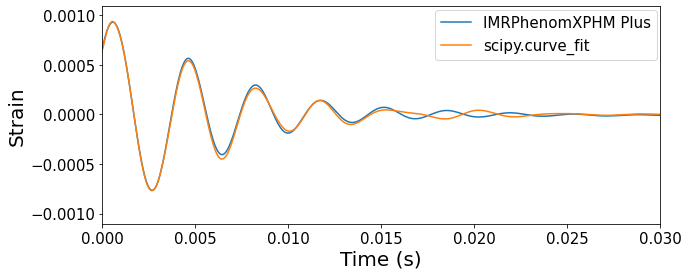

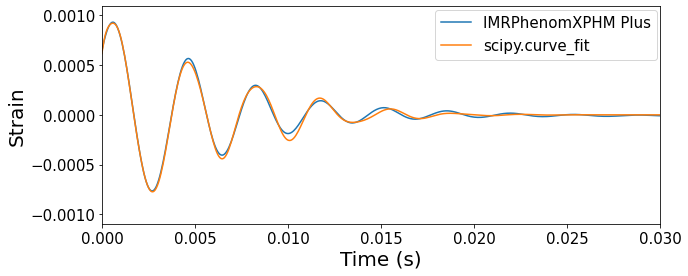

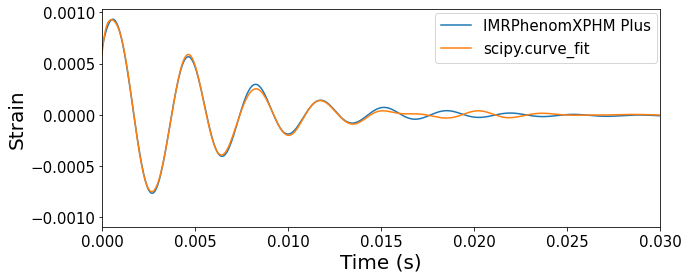

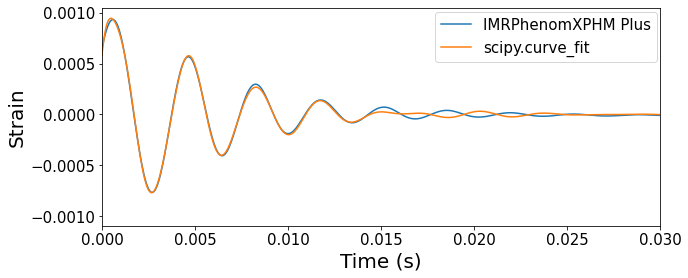

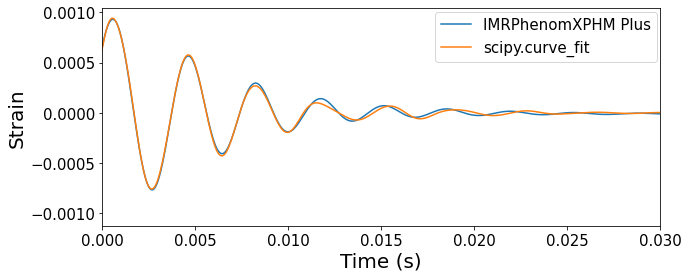

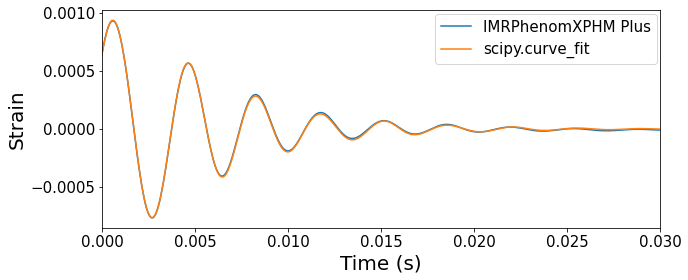

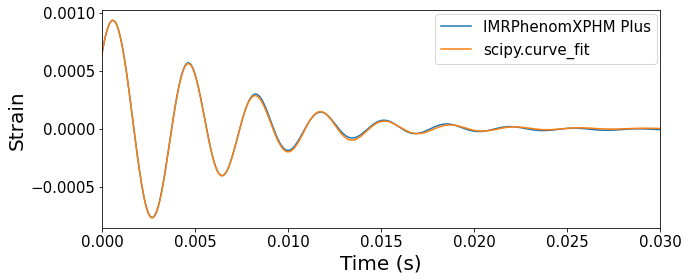

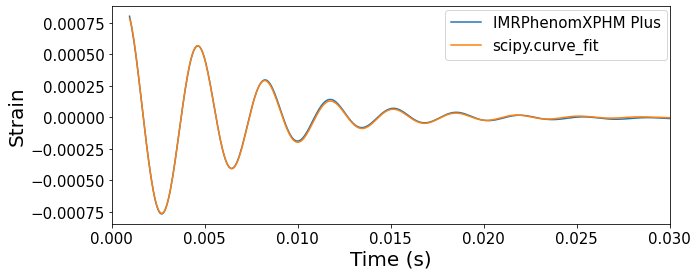

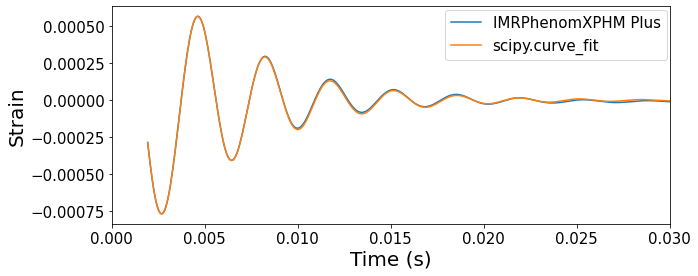

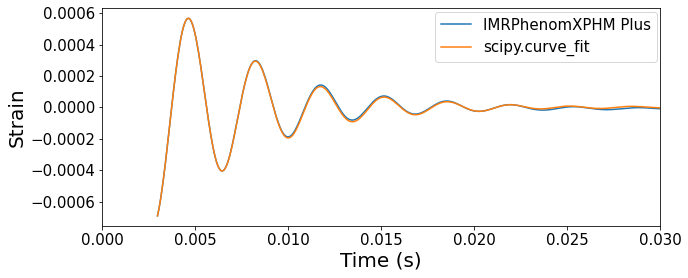

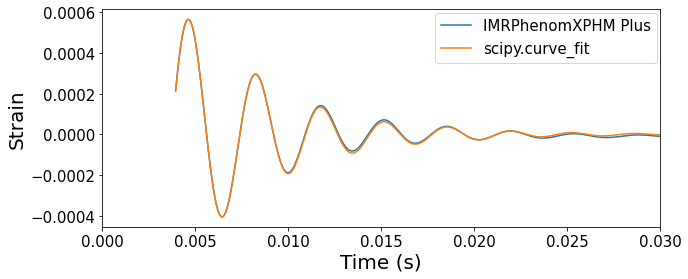

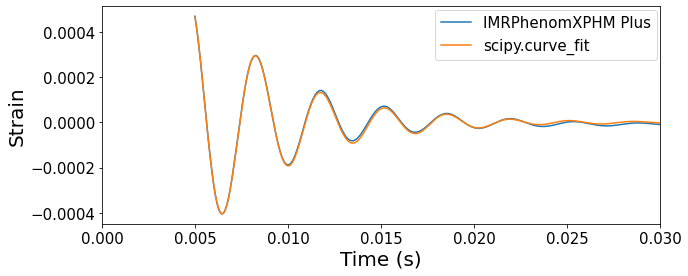

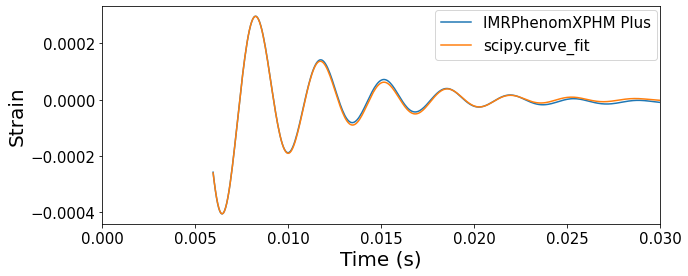

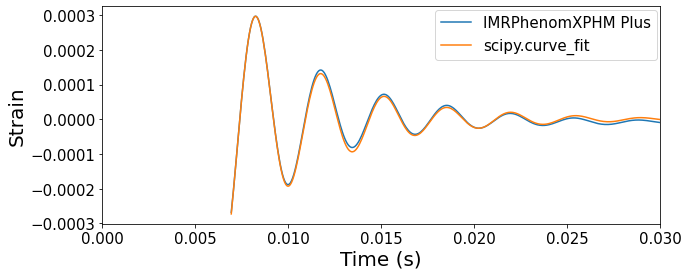

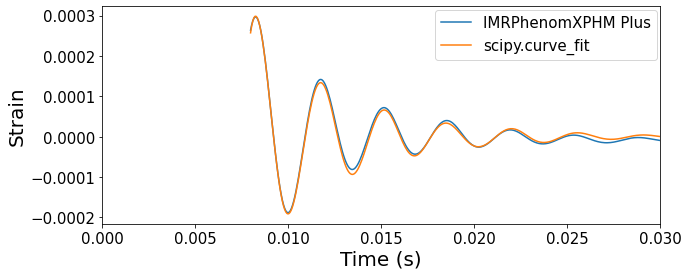

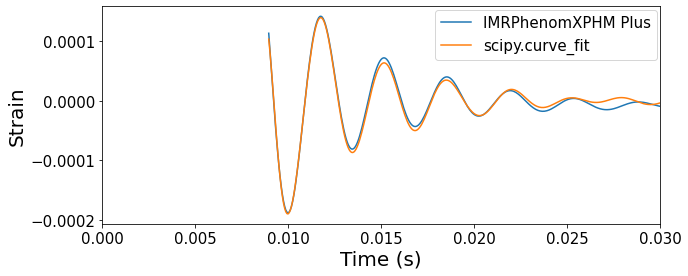

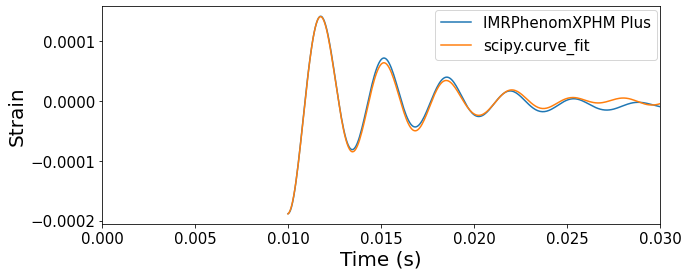

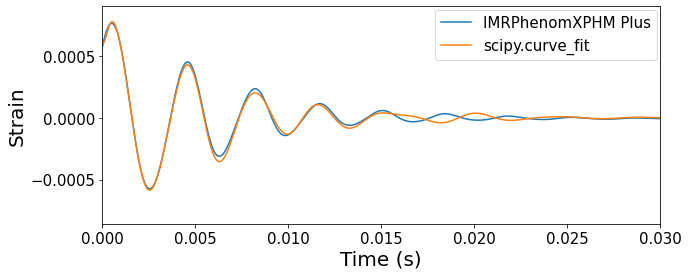

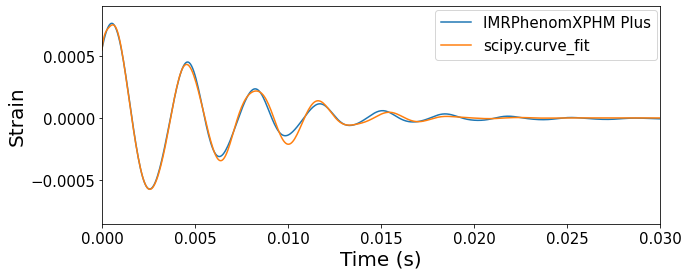

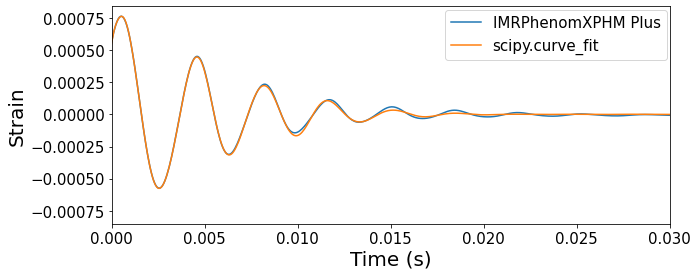

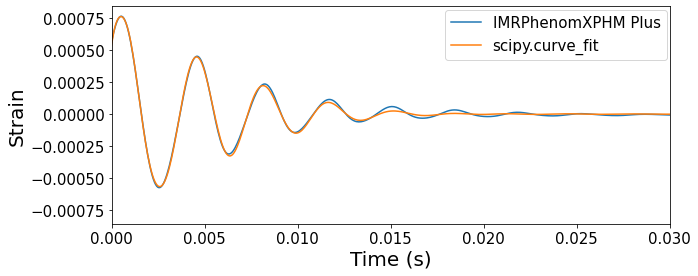

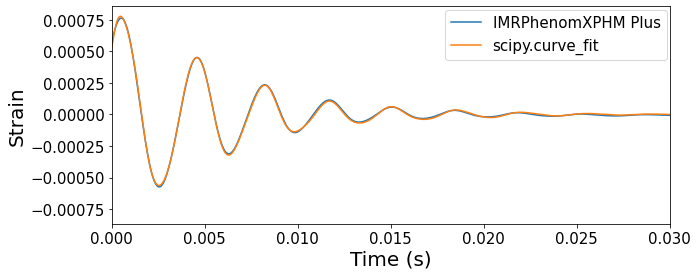

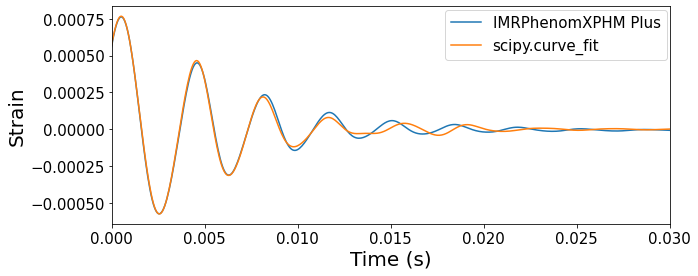

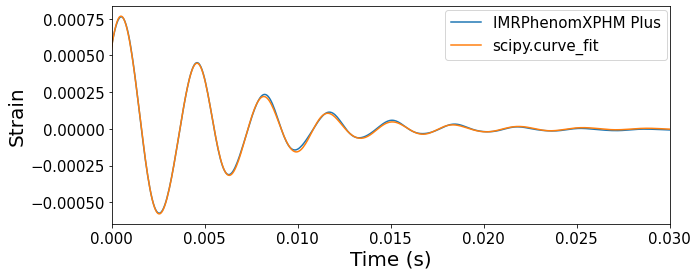

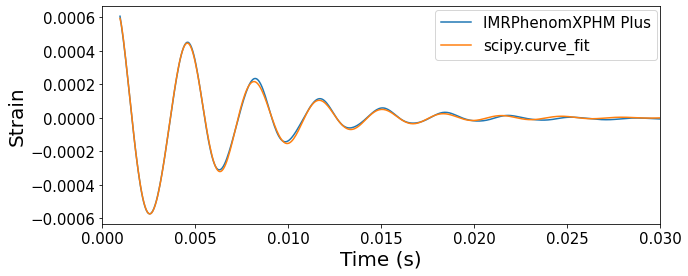

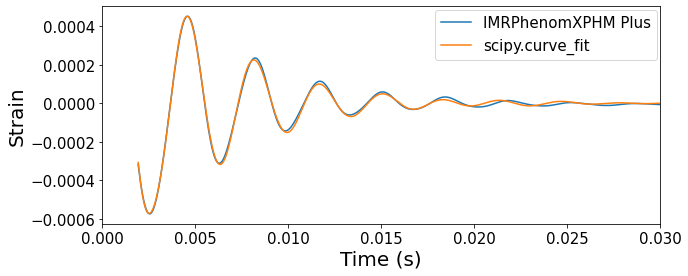

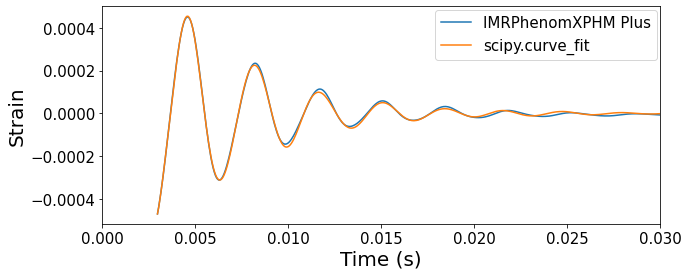

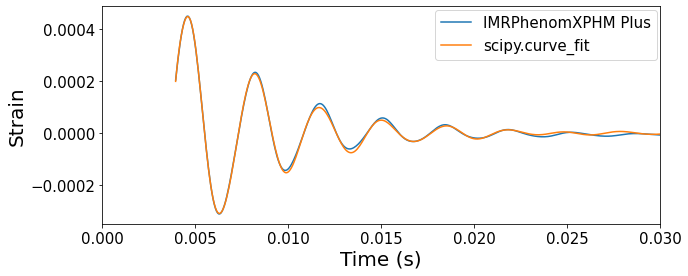

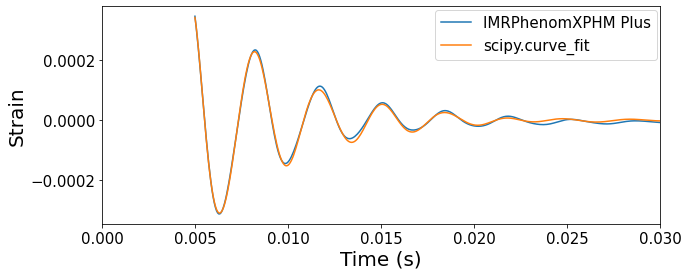

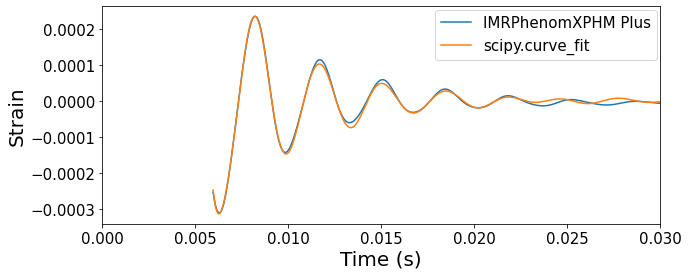

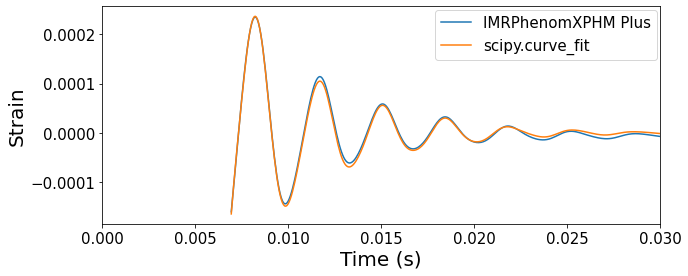

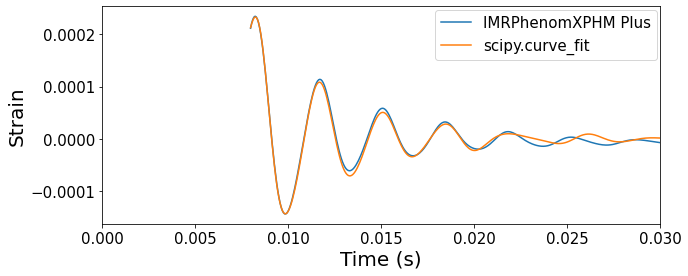

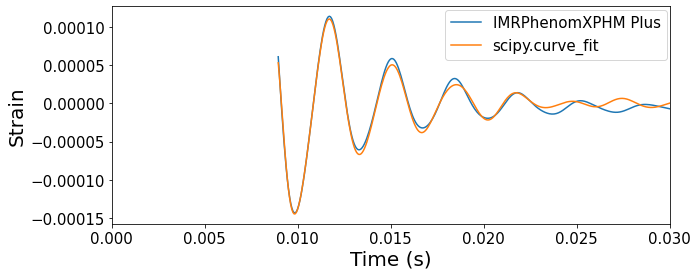

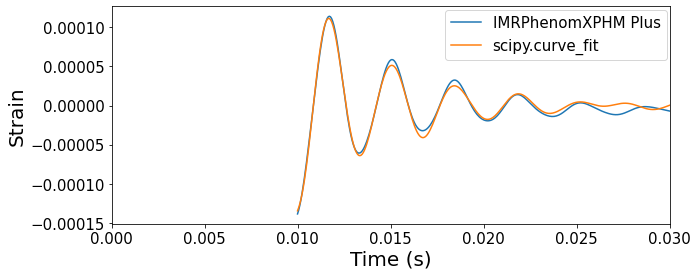

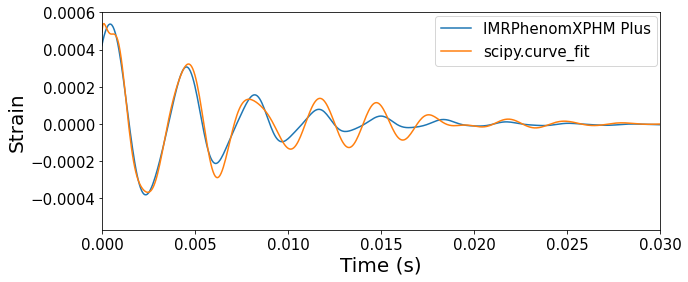

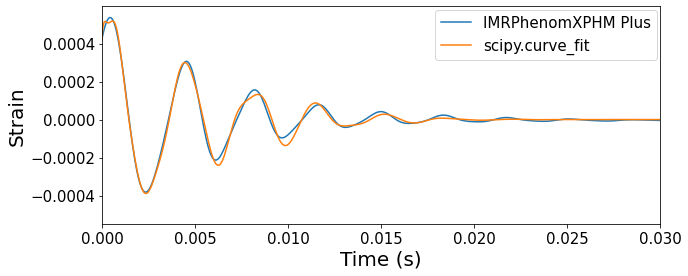

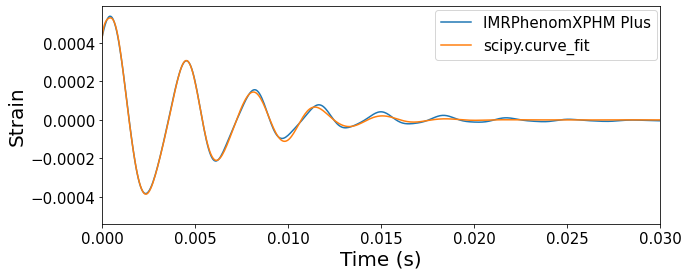

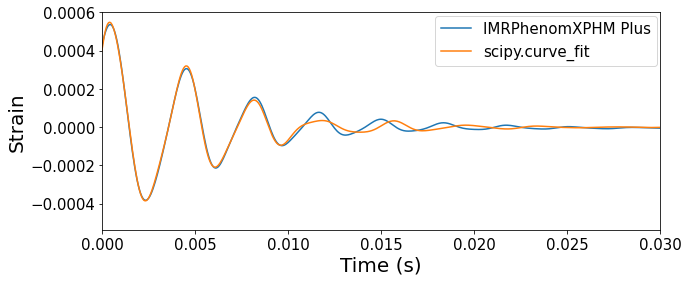

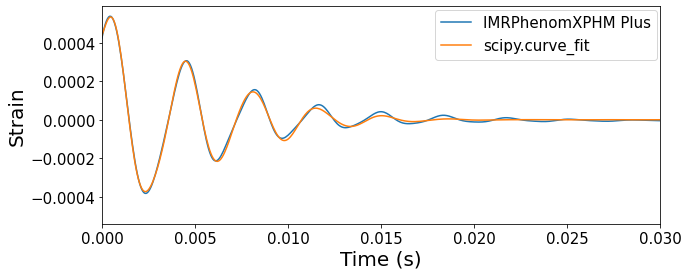

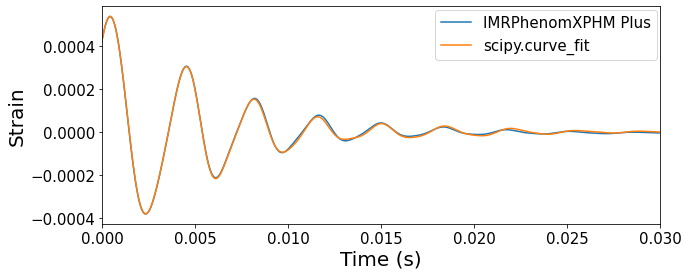

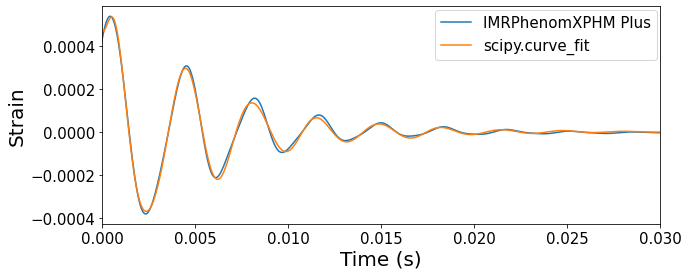

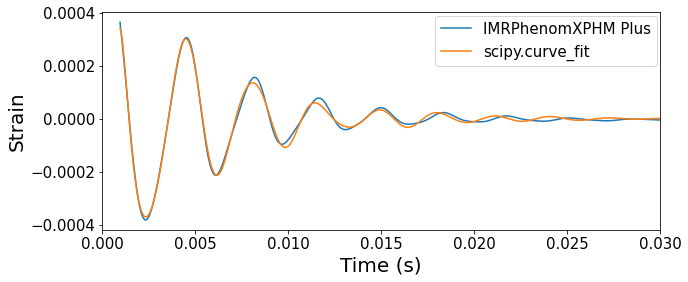

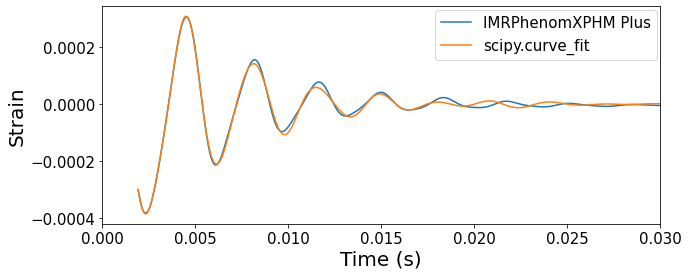

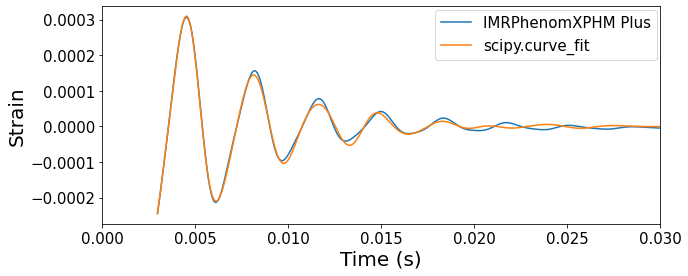

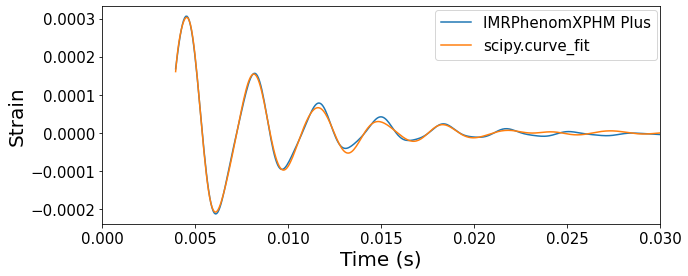

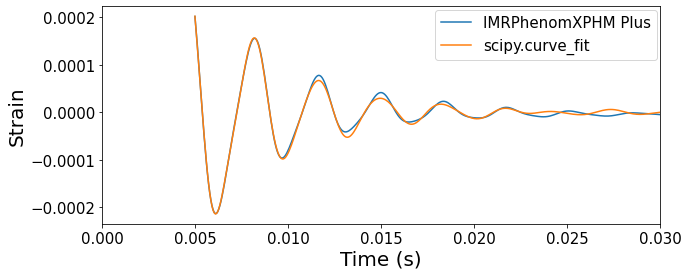

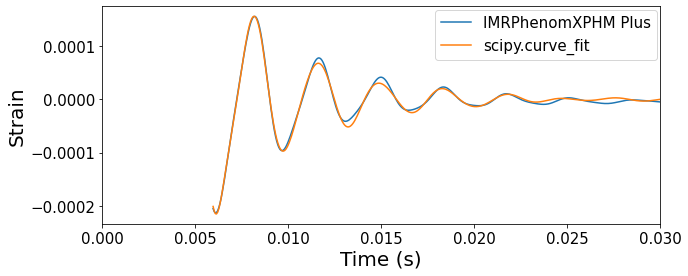

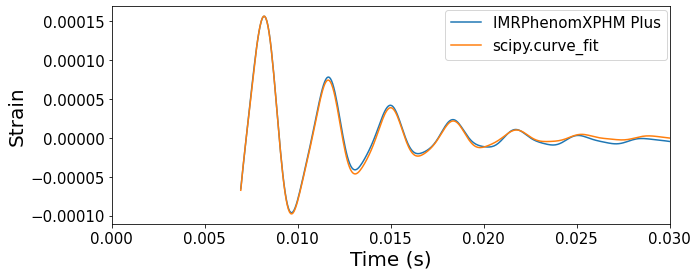

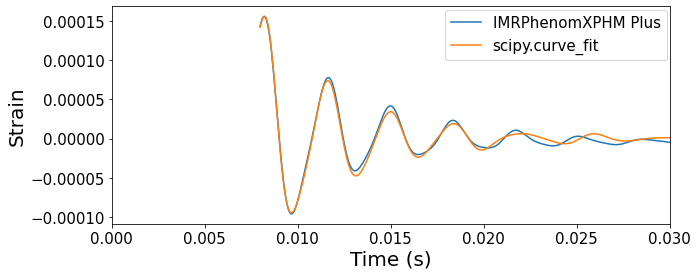

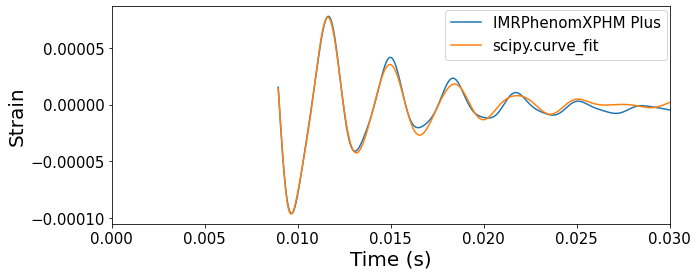

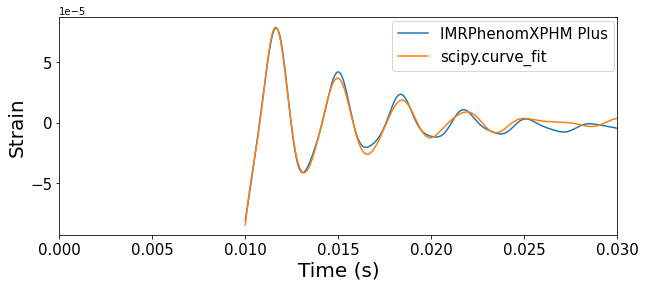

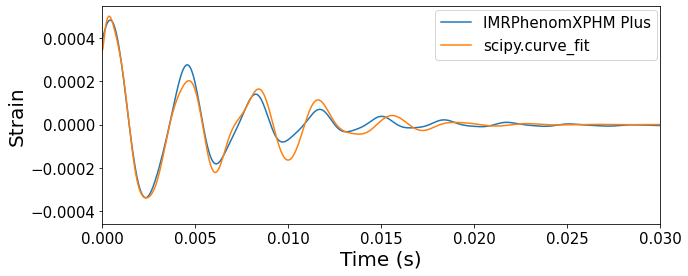

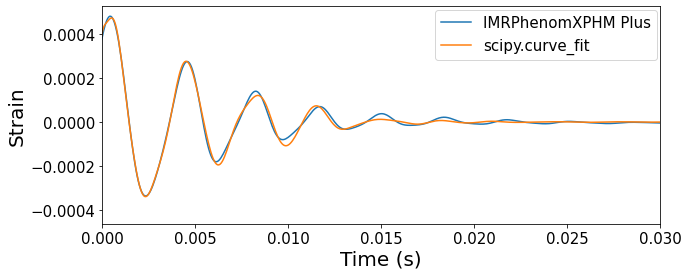

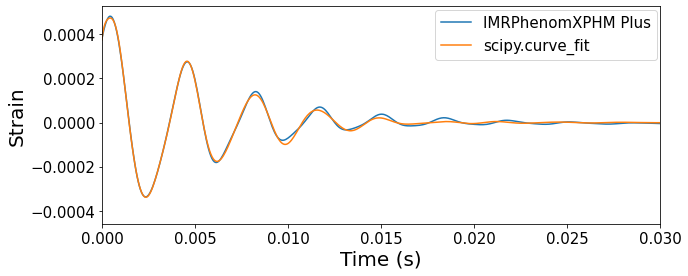

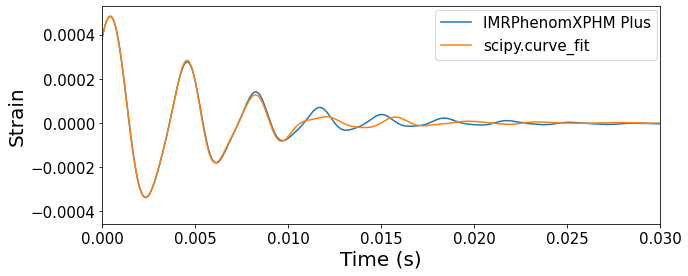

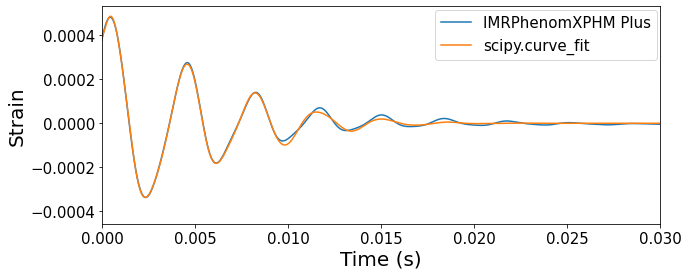

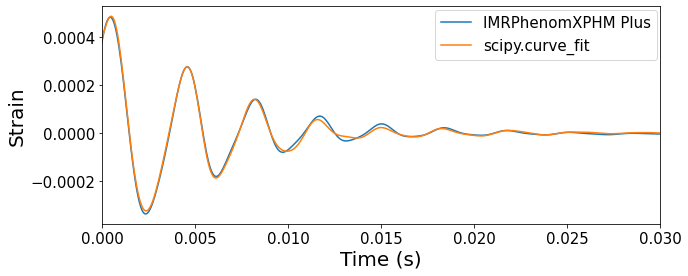

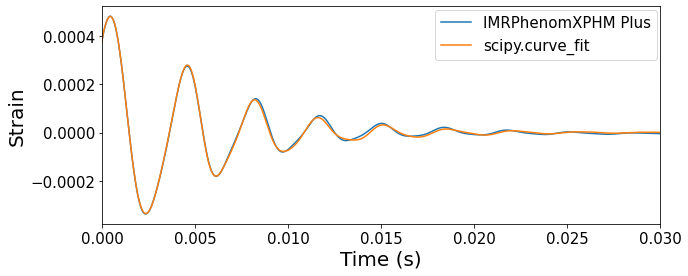

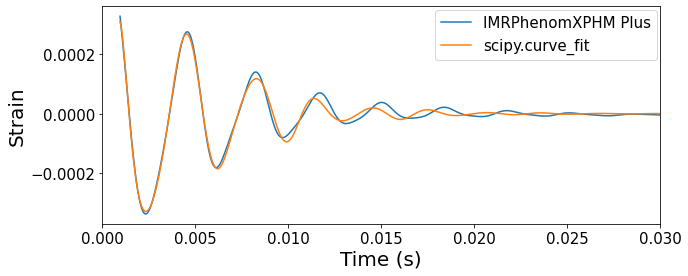

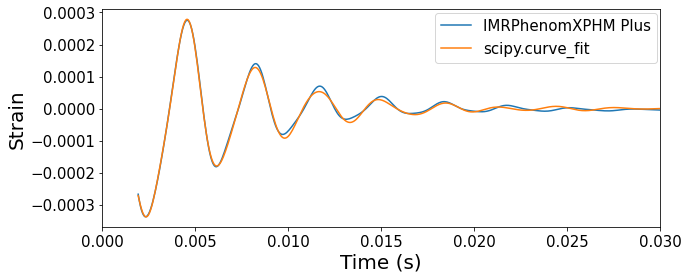

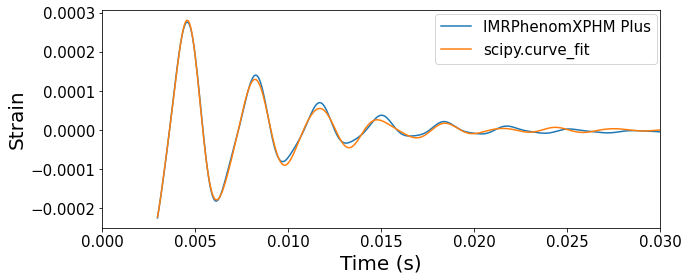

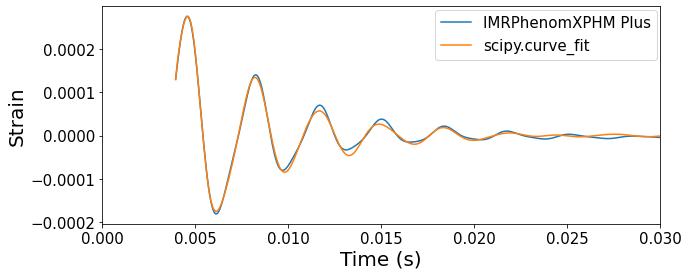

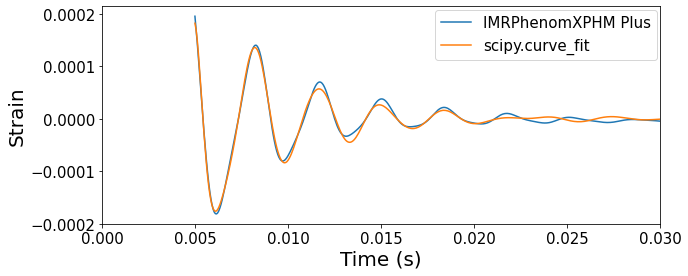

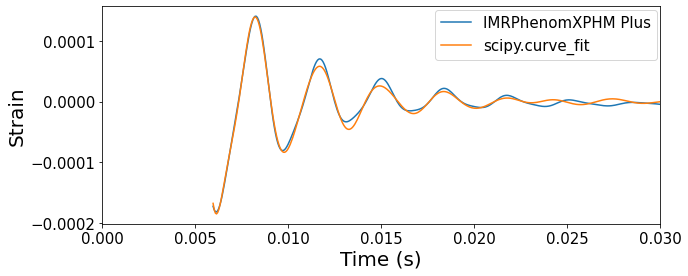

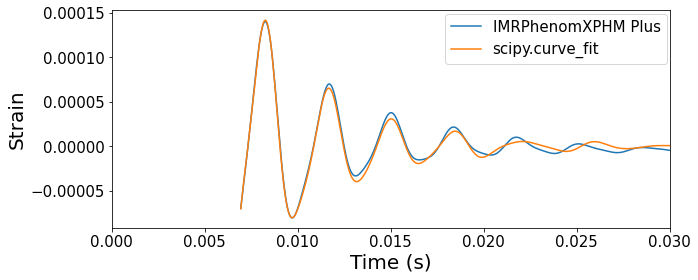

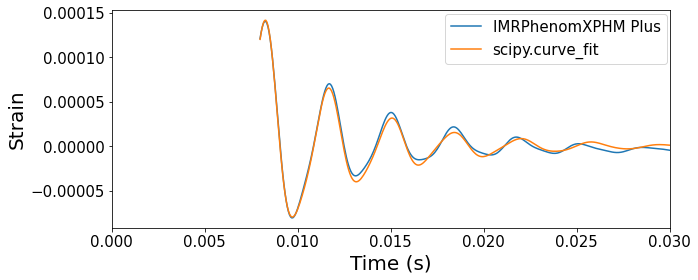

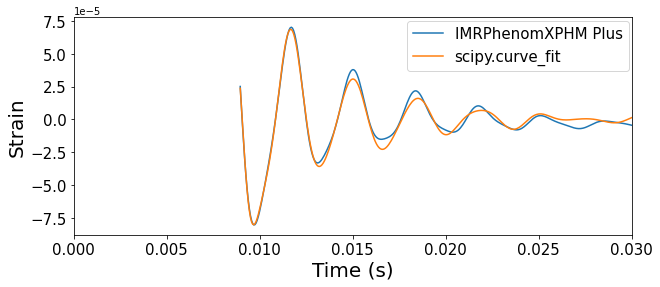

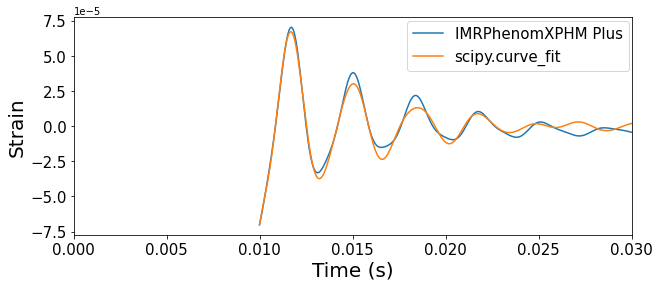

In [27]:
XPHM_eqM_addX_xyz = XPHMringdown_plots(40,39.99,0.5,0.5,0.5,0.5,0.5,0.5,.006,.011,.001,test,con,(con_lower,con_upper),'IMRPhenomXPHM')
XPHM_eqM_addX_xyz.to_csv('XPHM_eqM_addX_xyz.csv')